## SMM Estimation of Theories of Expectation Formation with Inflation Expectation

- The code is organized in following ways

  1. Each pair of a theory of expectation formation (re, se, ni, de, denim etc) and an assumed process of inflation process (ar1 or sv)  are encapsulated in a specific python class. 
    - the class initializes corresponding parameters of the inflation process and expectation formation 
    - and embodies a specific function that generates all the simulated moments of both inflation and expectations 
    
  2. A generally written objective function that computes the distances in moments as a function of parameters specific to the chosen model, moments, and the data. 
  3.  The general function is to be used to compute the specific objective function that takes parameter as the only input for the minimizer to work
  4.  Then a general function that does an optimization algorithm takes the specific objective function and estimates the parameters

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from numba import types
from numba.typed import Dict
import pandas as pd
from statsmodels.tsa.api import AutoReg as AR
lw = 4
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('ggplot')

## Model

In [111]:
from SMMEst import SimAR1, SimUCSV,ObjGen, ObjWeight,ParaEst
from SMMEst import StickyExpectationAR, StickyExpectationSV
from SMMEst import NoisyInformationAR, NoisyInformationSV
from SMMEst import DiagnosticExpectationAR, DiagnosticExpectationSV
from SMMEst import DENIHybridAR, DENIHybridSV

In [ ]:
## create some fake parameters and data to initialize model class
### not used for estimation

## AR1 parameters
ρ0,σ0 = 0.98, 0.10

history0 = SimAR1(ρ0,
                  σ0,
                  200)
real_time0 = history0[11:-2]

realized0 = history0[12:-1]

### UCSV inflation

p0_fake = 0 ## initial permanent component
γ_fake = 0.1 ## size of shock to the volatility
σs_now_fake = [0.2,0.3] ## volatility of permanent and transitory component

ucsv_fake = SimUCSV(γ_fake,
                    nobs = 200,
                    p0 = p0_fake,
                    )

xx_real_time,xx_p_real_time,vol_p_real_time,vol_t_real_time = ucsv_fake

xx_realized = xx_real_time[1:-1]

xx_real_time= np.array([xx_real_time,
                        xx_p_real_time,
                        vol_p_real_time,
                        vol_t_real_time]
                      )[:,0:-2]


### Rational Expectation (RE) + AR1

### Rational Expectation (RE) + SV

### Sticky Expectation (SE) + AR1

### Sticky Expectation (SE) + SV

In [112]:
## initialize the ar instance
sear0 = StickyExpectationAR(exp_para = np.array([0.2]),
                            process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

sear0.GetRealization(realized0)

In [113]:
## initialize the sv instance
sesv0 = StickyExpectationSV(exp_para = np.array([0.3]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

sesv0.GetRealization(xx_realized)

### Noisy Information (NI) + AR1


### Noisy Information (NI) + SV



In [114]:
## initialize the ar instance
niar0 = NoisyInformationAR(exp_para = np.array([0.1,0.2]),
                            process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

niar0.GetRealization(realized0)

In [115]:
## initial a sv instance
nisv0 = NoisyInformationSV(exp_para = np.array([0.3,0.2]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

nisv0.GetRealization(xx_realized)

###  Diagnostic Expectation(DE) + AR1

###  Diagnostic Expectation(DE) + SV

In [116]:
## initialize the ar instance
dear0 = DiagnosticExpectationAR(exp_para = np.array([0.5,0.2]),
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

dear0.GetRealization(realized0)

In [117]:
## initial a sv instance
desv0 = DiagnosticExpectationSV(exp_para = np.array([0.3,0.2]),
                               process_para = np.array([0.1]),
                               real_time = xx_real_time,
                               history = xx_real_time) ## history does not matter here, 

## get the realization 

desv0.GetRealization(xx_realized)

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + AR1

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + SV



In [120]:
## initialize the ar instance
deniar0 = DENIHybridAR(exp_para = np.array([0.1,0.4,0.3]),
                       process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

deniar0.GetRealization(realized0)

In [121]:
## initial a sv instance
denisv0 = DENIHybridSV(exp_para = np.array([0.1,0.3,0.2]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

denisv0.GetRealization(xx_realized)

## Data Estimation  

### Prepare the data 

#### Real-time Inflation data

In [122]:
import pandas as pd
real_time_index = pd.read_excel('../OtherData/RealTimeData/RealTimeInfQ.xlsx')

real_time_index.index = pd.to_datetime(real_time_index['DATE'],format='%Y%m%d')
real_time_index = real_time_index.drop(columns=['DATE'])

## turn index into yearly inflation
#real_time_index = pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100
real_time_inf = real_time_inf.dropna()

#### Inflation data 

In [123]:
###############
## monthly ### 
##############

InfM = pd.read_stata('../OtherData/InfM.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
dateM_str = dateM .dt.year.astype(int).astype(str) + \
             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM_str,freq='infer')

###############
## quarterly ##
###############

InfQ = InfM.resample('Q').last()
dateQ = pd.to_datetime(InfQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)

InfQ.index = pd.DatetimeIndex(dateQ_str,freq='infer')


###########################
#keep only needed variables 
############################

InfM = InfM[['Inf1y_CPIAU',
             'Inf1yf_CPIAU']]

InfQ = InfQ[['Inf1y_CPICore',
            'Inf1yf_CPICore']]

#### Expectation data

In [124]:
## expectation data from SPF 

PopQ = pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]
dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')
dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)
SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')

## expectation data from SCE
PopM = pd.read_stata('../SurveyData/InfExpM.dta')
PopM = PopM[-PopM.date.isnull()]
dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')
dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)
SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var',
              'SCE_Mean_rd','SCE_FE_rd','SCE_Disg_rd','SCE_Var_rd']].dropna(how='any')

In [125]:
print('SCE\n')
print(SCECPI.mean())

print('SPF\n')
print(SPFCPI.mean())

SCE

SCE_Mean       3.31
SCE_FE         1.06
SCE_Disg       6.59
SCE_Var       10.00
SCE_Mean_rd   -0.01
SCE_FE_rd     -0.00
SCE_Disg_rd    2.70
SCE_Var_rd     1.74
dtype: float64
SPF

SPFCPI_Mean    1.98
SPFCPI_FE     -0.15
SPFCPI_Disg    0.20
SPFCPI_Var     0.25
dtype: float64


In [126]:
## Combine expectation data and real-time data 

SPF_est= pd.concat([SPFCPI,
                    real_time_inf,
                    InfQ], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,
                     real_time_inf,
                     InfM], join='inner', axis=1)

#### History data 

In [127]:
## process parameters estimation AR1 
# period filter 
start_t='1995-01-01'
end_t = '2022-06-30'   

######################
### quarterly data ##
#####################

CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]

###################
### monthly data ##
###################

CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]

In [128]:
## history data, the series ends at the same dates with real-time data but startes earlier

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

## get the quarterly index 
indexQ = CPICQ.index

## get history data quarterly and monthly respectively 
af = indexQ >= st_t_history 
bf = indexQ <=ed_t_SPF
time_filter = np.logical_and(af,bf)
time_filter_idx = indexQ[time_filter]

historyQ = real_time_inf.loc[time_filter_idx]
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

#### Realization data

In [129]:
## realized 1-year-ahead inflation

realized_CPIC = np.array(SPF_est['Inf1yf_CPICore']) 
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU']) 

#### AR1 parameters 

In [130]:
######################
### quarterly data ##
#####################


CPICQ_demean = CPICQ

ARmodel = AR(CPICQ_demean,lags=1,trend='n')
ar_rs = ARmodel.fit()
rhoQ_est = ar_rs.params[0]
sigmaQ_est = np.sqrt(sum(ar_rs.resid**2)/(len(CPICQ)-1))

###################
### monthly data ##
###################

#Y = np.array(CPIM[12:])
#X = np.array(CPIM[:-12])

CPIM_demean = CPIM
ARmodel2 = AR(CPIM_demean,lags=1,trend='n')
ar_rs2 = ARmodel2.fit()
rhoM_est = ar_rs2.params[0]
sigmaM_est = np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [131]:
print('quarterly AR(1) estimates for CPI core:')
print(rhoQ_est)
print(sigmaQ_est)
print('monthly AR(1) estimates for CPI headline:')
print(rhoM_est)
print(sigmaM_est)

quarterly AR(1) estimates for CPI core:
1.0085387885646255
0.3987886129864195
monthly AR(1) estimates for CPI headline:
1.0011955736603089
0.42213997058158714


#### Data moments 

In [132]:
#####################################
## preparing data moments
#####################################

## Be careful with frequency here when computing auto-correlation. 
### SPF: quarters 
### SCE: month

#####################
## Professionals ####
#####################

### inflation moments 

realized_CPIC = realized_CPIC[~np.isnan(realized_CPIC)]
InfAV_data = np.mean(realized_CPIC)
InfVar_data = np.var(realized_CPIC)
InfATV_data = np.cov(np.stack( (realized_CPIC[4:],realized_CPIC[:-4]),axis = 0 ))[0,1]
## annual autocovariance

### expectation moments 
exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF = exp_data_SPF.rename(columns={"SPFCPI_Mean": "Forecast", "SPFCPI_FE": "FE",
                            "SPFCPI_Disg":"Disg","SPFCPI_Var":"Var"})

FEs_data = exp_data_SPF['FE']
Disgs_data = exp_data_SPF['Disg']
Vars_data = exp_data_SPF['Var']

FE_data = np.mean(FEs_data)
FEVar_data = np.var(FEs_data)
FEATV_data = np.cov(np.stack( (FEs_data[4:],FEs_data[:-4]),axis = 0))[0,1]  ## 4 quarters apart 
## annual autocovariance


Disg_data = np.mean(Disgs_data)
DisgVar_data = np.var(Disgs_data)
DisgATV_data = np.cov(np.stack( (Disgs_data[4:],Disgs_data[:-4]),axis = 0))[0,1]
Var_data = np.mean(Vars_data)
VarVar_data = np.var(Vars_data)
VarATV_data = np.cov(np.stack( (Vars_data[4:],Vars_data[:-4]),axis = 0))[0,1]
## annual autocovariance



data_moms_dct_SPF = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)
data_moms_dct_SPF['InfAV'] = InfAV_data
data_moms_dct_SPF['InfVar'] = InfVar_data
data_moms_dct_SPF['InfATV'] = InfATV_data

data_moms_dct_SPF['FE'] = FE_data
data_moms_dct_SPF['FEVar'] = FEVar_data
data_moms_dct_SPF['FEATV'] = FEATV_data
data_moms_dct_SPF['Disg'] = Disg_data
data_moms_dct_SPF['DisgVar'] = DisgVar_data
data_moms_dct_SPF['DisgATV'] = DisgATV_data
data_moms_dct_SPF['Var'] = Var_data
data_moms_dct_SPF['VarVar'] = VarVar_data
data_moms_dct_SPF['VarATV'] = VarATV_data


##########################
### For households 
##########################

#############################################################################################
############!!!!! using "xx_rd" moments only if one wants to control for individual fixed effects
###########################################################################################

control_ind_fe = True

if control_ind_fe:
    exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE_rd','SCE_Disg_rd','SCE_Var_rd']]
    exp_data_SCE = exp_data_SCE.rename(columns={"SCE_Mean": "Forecast", "SCE_FE_rd": "FE",
                                            "SCE_Disg_rd":"Disg","SCE_Var_rd":"Var"})
else:
    exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
    exp_data_SCE = exp_data_SCE.rename(columns={"SCE_Mean": "Forecast", "SCE_FE": "FE",
                                            "SCE_Disg":"Disg","SCE_Var":"Var"})

## inflation moments 

realized_CPI = realized_CPI[~np.isnan(realized_CPI)]

InfAV_data = np.mean(realized_CPI)
InfVar_data = np.var(realized_CPI)
InfATV_data = np.cov(np.stack( (realized_CPI[12:],realized_CPI[:-12]),axis = 0 ))[0,1]

## expectation moments 
FEs_data = exp_data_SCE['FE']
Disgs_data = exp_data_SCE['Disg']
Vars_data = exp_data_SCE['Var']

FE_data = np.mean(FEs_data)
FEVar_data = np.var(FEs_data)
FEATV_data = np.cov(np.stack( (FEs_data[12:],FEs_data[:-12]),axis = 0 ))[0,1]

Disg_data = np.mean(Disgs_data)
DisgVar_data = np.var(Disgs_data)
DisgATV_data = np.cov(np.stack( (Disgs_data[12:],Disgs_data[:-12]),axis = 0))[0,1]
Var_data = np.mean(Vars_data)
VarVar_data = np.var(Vars_data)
VarATV_data = np.cov(np.stack( (Vars_data[12:],Vars_data[:-12]),axis = 0))[0,1]


data_moms_dct_SCE = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)
data_moms_dct_SCE['InfAV'] = InfAV_data
data_moms_dct_SCE['InfVar'] = InfVar_data
data_moms_dct_SCE['InfATV'] = InfATV_data
data_moms_dct_SCE['FE'] = FE_data
data_moms_dct_SCE['FEVar'] = FEVar_data
data_moms_dct_SCE['FEATV'] = FEATV_data
data_moms_dct_SCE['Disg'] = Disg_data
data_moms_dct_SCE['DisgVar'] = DisgVar_data
data_moms_dct_SCE['DisgATV'] = DisgATV_data
data_moms_dct_SCE['Var'] = Var_data
data_moms_dct_SCE['VarVar'] = VarVar_data
data_moms_dct_SCE['VarATV'] = VarATV_data


############# need to compute the unconditional moments here 

In [133]:
print(dict(data_moms_dct_SPF))
print(dict(data_moms_dct_SCE))

{'InfAV': 2.1455934047698975, 'InfVar': 1.1447235345840454, 'InfATV': 0.11460328494844499, 'FE': -0.1495925784111023, 'FEVar': 1.0320063829421997, 'FEATV': 0.0058074145722507384, 'Disg': 0.20040778815746307, 'DisgVar': 0.041993219405412674, 'DisgATV': 0.009651332602339498, 'Var': 0.24647797656299944, 'VarVar': 0.001630119840358011, 'VarATV': 0.0008500399728163831}
{'InfAV': 2.2507858276367188, 'InfVar': 3.959151268005371, 'InfATV': 0.4169206366735583, 'FE': -0.003919071052223444, 'FEVar': 0.18712414801120758, 'FEATV': -0.07942981809256566, 'Disg': 2.6953561305999756, 'DisgVar': 0.1455652117729187, 'DisgATV': -0.014691111825971305, 'Var': 1.7384371757507324, 'VarVar': 0.03977144882082939, 'VarATV': -0.005225160060607234}


### Data moments

In [134]:
## real time and history 

################
## quarterly ###
#################

real_time_Q_ar = np.array(SPF_est['RTCPICore'])
history_Q_ar = np.array(historyQ['RTCPICore'])
process_paraQ_est_ar = np.array([rhoQ_est,sigmaQ_est])

##############
## monthly ###
#############

real_time_M_ar = np.array(SCE_est['RTCPI'])
history_M_ar = np.array(historyM['RTCPI'])

process_paraM_est_ar = np.array([rhoM_est,
                                 sigmaM_est])

#### SV  parameters and data  

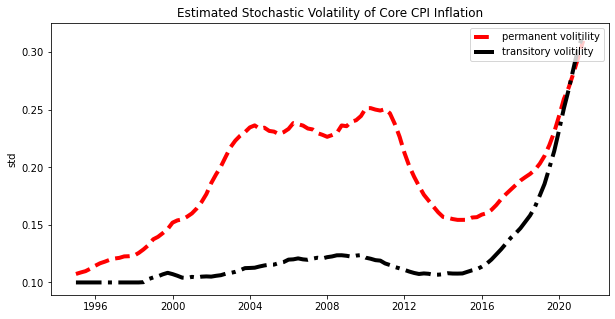

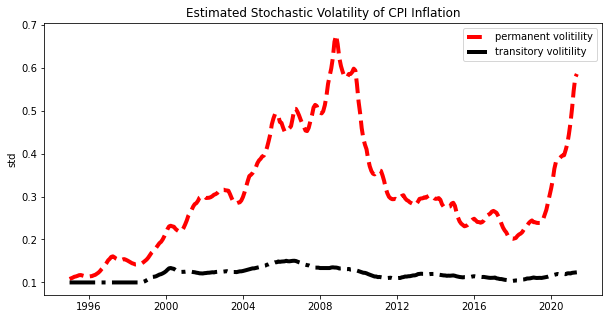

In [135]:
################
## quarterly ##
################

### quarterly data 
### exporting inflation series for process estimation using UCSV model in matlab

CPICQ.to_excel("../OtherData/CPICQ.xlsx")  ## this is for matlab estimation of UCSV model

################
## monthly ####
################

### process parameters estimation 

### exporting monthly inflation series for process estimation using UCSV model in matlab
CPIM.to_excel("../OtherData/CPIM.xlsx")  ## this is for matlab estimation of UCSV model

##########################################################################
##########################################################################
##########################################################################
## use matlab code stockwatson.m to estimate UCSV model before moving on!
##########################################################################
##########################################################################
##########################################################################
##########################################################################


## process parameters estimation for SV 

################
## quarterly ##
################

### import the estimated results 
CPICQ_UCSV_Est = pd.read_excel('../OtherData/UCSVestQ.xlsx')  
CPICQ_UCSV_Est.index = pd.to_datetime(CPICQ_UCSV_Est['date'],format='%Y%m%d')
CPICQ_UCSV_Est = CPICQ_UCSV_Est.drop(columns=['date'])
CPICQ_UCSV_Est = CPICQ_UCSV_Est.rename(columns = {'sd_eps':'sd_p_est',
                                      'sd_eta':'sd_t_est',
                                      'tau':'p'})  ## Loading ucsv model estimates 



################
## monthly ####
################

### import the estimated results 
CPIM_UCSV_Est = pd.read_excel('../OtherData/UCSVestM.xlsx')  
CPIM_UCSV_Est.index =pd.to_datetime(CPIM_UCSV_Est['date'],format='%Y%m%d')
CPIM_UCSV_Est = CPIM_UCSV_Est.drop(columns=['date'])
CPIM_UCSV_Est = CPIM_UCSV_Est.rename(columns = {'sd_eps':'sd_p_est',
                                                'sd_eta':'sd_t_est',
                                                'tau':'p'})  ## Loading ucsv model estimates 

########################################################################################
## be careful with the order, I define eta as the permanent and eps to be the transitory
 ######################################################################################
    

### quarterly plot 

plt.figure(figsize=(10,5))
plt.plot(CPICQ_UCSV_Est['sd_p_est'],
         'r--',
          lw = lw,
         label='permanent volatility')
plt.plot(CPICQ_UCSV_Est['sd_t_est'],
         'k-.',
         lw = lw,
         label='transitory volatility')
plt.title('Estimated Stochastic Volatility of Core CPI Inflation')
plt.ylabel('std')
plt.legend(loc=1)
plt.savefig('../graphs/inflation/UCSVQ.png')
    
### monthly plot 

plt.figure(figsize=(10,5))
plt.plot(CPIM_UCSV_Est['sd_p_est'],
         'r--',
          lw = lw,
         label='permanent volatility')
plt.plot(CPIM_UCSV_Est['sd_t_est'],
         'k-.',
         lw = lw,
         label='transitory volatility')
plt.title('Estimated Stochastic Volatility of CPI Inflation')
plt.ylabel('std')
plt.legend(loc=1)
plt.savefig('../graphs/inflation/UCSVM.png')

In [136]:
#########################################################
## specific to SV model  
######################################################

#############
## quarterly 
##############

n_burn_rt_historyQ = len(CPICQ_UCSV_Est) - len(historyQ)  

history_yQ = np.array(historyQ['RTCPICore'])
history_vol_pQ = np.array(CPICQ_UCSV_Est['sd_p_est'][n_burn_rt_historyQ:])**2  ## permanent
history_vol_tQ = np.array(CPICQ_UCSV_Est['sd_t_est'][n_burn_rt_historyQ:])**2 ## transitory

#history_volsQ = np.array([history_vol_pQ,
#                          history_vol_tQ])
history_pQ = np.array(CPICQ_UCSV_Est['p'][n_burn_rt_historyQ:])

## to burn 
n_burn_Q = len(history_pQ) - len(SPF_est['RTCPI'])
real_time_yQ = history_yQ[n_burn_Q:]
real_time_vol_pQ = history_vol_pQ[n_burn_Q:]
real_time_vol_tQ = history_vol_tQ[n_burn_Q:]
real_time_pQ = history_pQ[n_burn_Q:]

############
## monthly
############

n_burn_rt_historyM = len(CPIM_UCSV_Est) - len(historyM)  

history_yM = np.array(historyM['RTCPI'])
history_vol_pM = np.array(CPIM_UCSV_Est['sd_p_est'][n_burn_rt_historyM:])**2
history_vol_tM = np.array(CPIM_UCSV_Est['sd_t_est'][n_burn_rt_historyM:])**2

#history_volsM = np.array([history_vol_pM,
#                          history_vol_tM])  ## order is import 

history_pM = np.array(CPIM_UCSV_Est['p'][n_burn_rt_historyM:])

## to burn 
n_burn_M = len(history_pM) - len(SCE_est['RTCPI'])
real_time_yM = history_yM[n_burn_M:]
real_time_vol_pM = history_vol_pM[n_burn_M:]
real_time_vol_tM = history_vol_tM[n_burn_M:]
real_time_pM = history_pM[n_burn_M:]

In [137]:
## generate histories and real time array 

history_Q_sv = np.array([history_yQ,
                           history_pQ,
                           history_vol_pQ,
                           history_vol_tQ])
history_M_sv = np.array([history_yM,
                           history_pM,
                           history_vol_pM,
                           history_vol_tM])

real_time_Q_sv = np.array([real_time_yQ,
                         real_time_pQ,
                         real_time_vol_pQ,
                         real_time_vol_tQ])
real_time_M_sv = np.array([real_time_yM,
                         real_time_pM,
                         real_time_vol_pM,
                         real_time_vol_tM])

In [138]:
## process parameters 
process_paraQ_est_sv = np.array([0.2])
process_paraM_est_sv = np.array([0.2])

### Test  Estimation

### Estimation 

In [139]:
agents_list = ['SPF','SCE']

process_list = ['AR','SV']

ex_model_list = ['SE',
                 'NI',
                 'DE',
                 'DENI'
                ]
nb_ex_model = len(ex_model_list)

moments_list = [['FE','FEVar','FEATV'],
               ['FE','FEVar','FEATV','Disg','DisgVar','DisgATV'],
               ['FE','FEVar','FEATV','Disg','DisgVar','DisgATV','Var','VarVar','VarATV']]
nb_moments = len(moments_list)

how_list =['2-step','Joint']

moments_list_general = ['FE','FE+Disg','FE+Disg+Var']

model_list = [sear0,niar0,dear0,deniar0,
             sesv0,nisv0,desv0,denisv0]

algorithm_list = ['trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr']


algorithm_joint_list = ['trust-constr',
                        'trust-constr',
                        'trust-constr',
                        'trust-constr',
                        None,
                        None,
                        None,
                        None]

bns_list =[((0,1),),
           ((0,3),(0,3),),
           ((-2,2),(0,5),),
           ((-3,3),(0,3),(0,3),),
           ((0,1),),
           ((0,3),(0,3),),
           ((-2,2),(0,np.inf),),
           ((-3,3),(0,3),(0,3),)]

bns_joint_list =[((0,1),(0.9,1),(0,np.inf),),
                 ((0,3),(0,3),(0.9,1),(0,np.inf),),
                 ((-2,2),(0,5),(0.9,1),(0,np.inf),),
                 ((-3,3),(0,3),(0,3),(0.9,1),(0,np.inf),),
                 None,
                 None,
                 None,
                 None]

data_mom_dict_list = [data_moms_dct_SPF,
                      data_moms_dct_SCE]

process_paras_list = [process_paraQ_est_ar,
                      process_paraQ_est_sv,
                      process_paraM_est_ar,
                      process_paraM_est_sv]

realized_list = [realized_CPIC.astype(np.float64),
                 realized_CPI.astype(np.float64)]

real_time_list = [np.array(real_time_Q_ar),
                 np.array(real_time_Q_sv),  ## 4 x t array 
                np.array(real_time_M_ar),
                 np.array(real_time_M_sv)]  ## 4 x t array 

history_list = [np.array(history_Q_ar),
               np.array(history_Q_sv),     ## 4 x t array 
               np.array(history_M_ar), 
               np.array(history_M_sv)]     ## 4 x t array 

## parameter guesses 
guesses_list = [np.array([0.3]),  ## se lbd 
               np.array([0.5,0.8]),  ## ni sigma_pb, sigma_pr
               np.array([0.3,0.4]),   ## de theta theta_sigma
               np.array([0.1,0.2,0.3])
               ]  ## deni theta, sigma_pb, sigma_pr

guesses_joint_list = [np.array([0.3,0.97,0.1]),            ## se lbd 
                       np.array([0.1,0.2,0.95,0.1]),      ## ni sigma_pb, sigma_pr
                       np.array([0.3,0.4,0.95,0.1]),      ## de theta theta_sigma
                       np.array([0.1,0.2,0.3,0.95,0.1]),  ## theta, sigma_pb, sigma_pr  
                       ## for sv models not used
                       np.array([0.3,0.2]),            ## se lbd 
                       np.array([0.1,0.2,0.2]),      ## ni sigma_pb, sigma_pr
                       np.array([0.3,0.4,0.2]),      ## de theta theta_sigma
                       np.array([0.1,0.2,0.2])
                     ]  ## deni theta, sigma_pb, sigma_pr]

n_exp_paras_list = [1,
                    2,
                    2,
                    3]


## names labels 


se_ar_names = [r'$\hat\lambda$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\lambda$', 
                   r'$\rho$',
                   r'$\sigma$']


ni_ar_names = [r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'NI: $\rho$',
                   r'NI: $\sigma$']


de_ar_names = [r'$\hat\theta$',
                   r'$\sigma_\theta$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\theta$',
                   r'$\sigma_\theta$',
                   r'$\rho$',
                   r'$\sigma$']


deni_ar_names = [r'$\hat\theta$',
                   r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\rho$',
                   r'$\sigma$',
                   r'$\hat\theta$',
                   r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\rho$',
                   r'$\sigma$']

se_sv_names = [r'$\hat\lambda$',
               r'$\gamma$']


ni_sv_names = [r'$\hat\sigma_{pb}$',
               r'$\hat\sigma_{pr}$',
               r'$\gamma$']


de_sv_names = [r'$\hat\theta$',
               r'$\sigma_\theta$',                   
               r'$\gamma$']


deni_sv_names = [r'$\hat\theta$',
                   r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{pr}$',
                   r'$\gamma$']


names_list = [se_ar_names,
             ni_ar_names,
             de_ar_names,
             deni_ar_names,
             se_sv_names,
             ni_sv_names,
             de_sv_names,
             deni_sv_names]

################################################################################
## estimate the model for different agents, theory, inflation process and joint/theory 
#################################################################################

paras_list = []
paras_step2_list = []
paras_joint_list = []
paras_joint_step2_list = []


for agent_id,agent in enumerate(agents_list):
    print(agent)
    realized_this = realized_list[agent_id]
    data_mom_dict_this = data_mom_dict_list[agent_id]
    for pg_id,process in enumerate(process_list):
        print(process)
        ## history and real-time inflation that is fed in the model depends on agent type and process
        agent_process_id = agent_id*2+pg_id       
        process_paras_this = process_paras_list[agent_process_id]
        real_time_this = real_time_list[agent_process_id]
        history_this = history_list[agent_process_id] 
        
        for exp_id,ex_model in enumerate(ex_model_list):
            print(ex_model)
            model_idx  = pg_id*nb_ex_model+exp_id
            print(model_idx)
            model_instance = model_list[model_idx]
            alg_this= algorithm_list[model_idx]
            bounds_this = bns_list[model_idx]
            print('2-step estimation uses algorithm'+alg_this)
            print('bounds for parameters'+str(bounds_this))
            alg_joint_this= algorithm_joint_list[model_idx]
            bounds_joint_this = bns_joint_list[model_idx]
            names_this = names_list[model_idx]

            ## feed inputs to the instance 
            instance = model_instance

            print(instance)
            instance.GetRealization(realized_this)
            instance.real_time = real_time_this
            instance.history = history_this
            instance.process_para = process_paras_this 
            
            ## model-specific estimates holder 
            
            paras_list_this_model = []
            paras_step2_list_this_model = []
            paras_joint_list_this_model = []
            paras_joint_step2_list_this_model = []
            
            ## specific objetive function to minimize (only for expectation)

            for mom_id, moments_this in enumerate(moments_list):
                print(moments_this)
                print('Step 1')
                def Obj_this(paras_this):  
                    scalor = ObjGen(instance,
                                    paras = paras_this,
                                    data_mom_dict = data_mom_dict_this,
                                    moment_choice = moments_this,
                                    how ='expectation')
                    return scalor
                
                guess_this = guesses_list[exp_id]
                ## estimating
                para_est  = ParaEst(Obj_this,
                                 para_guess = guess_this,
                                 method= alg_this,
                                bounds = bounds_this)
                ## same para est
                para_est = np.round(para_est,2)
                print('Step 1:'+str(para_est))
                paras_list_this_model.append(para_est)
                paras_list.append(para_est)
                if len(para_est)>0:
                    ## compute the efficient weighting matrix 
                    instance.exp_para = para_est
                    smm_dict_this = instance.SMM()
                    distance = np.array([smm_dict_this[mom] - data_mom_dict_this[mom] for mom in moments_this]) 
                    distance_diag = np.diag(distance*distance.T)
                    wm1st = np.linalg.inv(distance_diag)

                    ## 2-step estimation using efficient matrix 
                    def Obj_this_step2(paras_this):
                        scalor = ObjWeight(instance,
                                           paras = paras_this,
                                           weight = wm1st,
                                           data_mom_dict = data_mom_dict_this,
                                           moment_choice = moments_this,
                                           how ='expectation')
                        return scalor
                    ## re-estimating
                    para_est_step2  = ParaEst(Obj_this_step2,
                                        para_guess = guess_this,
                                        method= alg_this,
                                        bounds = bounds_this)
                else:
                    para_est_step2 = np.array([])
                ## same para est
                para_est_step2 = np.round(para_est_step2,2)

                print('Step 2:'+str(para_est_step2))
                paras_step2_list_this_model.append(para_est_step2)
                paras_step2_list.append(para_est_step2)
                
                
                ##  joint estimation 
                n_exp_paras_this = n_exp_paras_list[exp_id]
                moments_this_ = moments_this+['InfAV','InfVar','InfATV'] ## added inflation moments 
                
                if pg_id <=0: ## no joint estimation for SV models 
                    def Obj_joint_this(paras):
                        scalor = ObjGen(instance,
                                        paras = paras,
                                        data_mom_dict = data_mom_dict_this,
                                        moment_choice = moments_this_,
                                        how = 'joint',
                                        n_exp_paras = n_exp_paras_this)
                        return scalor

                    guess_this_ = guesses_joint_list[model_idx]
                    ## estimating
                    paras_joint_est = ParaEst(Obj_joint_this,
                                              para_guess = guess_this_,
                                              method= alg_joint_this,
                                              bounds = bounds_joint_this) ##Nelder-Mead  
                    if len(paras_joint_est)>0:
                        ## compute the efficient weighting matrix 
                        instance.exp_para = paras_joint_est[0:n_exp_paras_this]     
                        instance.process_para = paras_joint_est[n_exp_paras_this:]
                        smm_dict_this = instance.SMM()
                        distance = np.array([smm_dict_this[mom] - data_mom_dict_this[mom] for mom in moments_this_]) 
                        distance_diag = np.diag(distance*distance.T)
                        wm1st = np.linalg.inv(distance_diag)

                        ## 2-step estimation using efficient matrix 
                        def Obj_joint_this_step2(paras_this):
                            scalor = ObjWeight(instance,
                                               paras = paras_this,
                                               weight = wm1st,
                                               data_mom_dict = data_mom_dict_this,
                                               moment_choice = moments_this_,
                                               how ='joint',
                                               n_exp_paras = n_exp_paras_this)
                            return scalor
                        ## re-estimating
                        para_est_joint_step2  = ParaEst(Obj_joint_this_step2,
                                                        para_guess = guess_this_,
                                                        method = alg_joint_this,
                                                        bounds = bounds_joint_this)     #  Nelder-Mead         
                    else:
                        para_est_joint_step2 = np.array([])
                
                else:
                    paras_joint_est = np.array([])
                    para_est_joint_step2 = np.array([])
                
                ## save in the list 
                paras_joint_est = np.round(paras_joint_est,2)
                print('Step 1:'+str(paras_joint_est))
                paras_joint_list_this_model.append(paras_joint_est)
                paras_joint_list.append(paras_joint_est)
                
                para_est_joint_step2 = np.round(para_est_joint_step2,2)
                print('Step 2:'+str(para_est_joint_step2))
                paras_joint_step2_list_this_model.append(para_est_joint_step2)
                paras_joint_step2_list.append(para_est_joint_step2)
            
            
            ### export model-specific estimates 
            names = names_list[model_idx]
            #print(paras_step2_list_this_model)
            #print(paras_joint_step2_list_this_model)
            para_est_tab_this_model = pd.DataFrame(paras_step2_list_this_model,
                                            index = moments_list_general)
            para_est_process_tab_this_model = pd.DataFrame([process_paras_this]*nb_moments,
                                            index = moments_list_general)
            para_joint_est_tab_this_model = pd.DataFrame(paras_joint_step2_list_this_model,
                                            index = moments_list_general)
            para_all_est_tab_this_model = pd.concat([para_est_tab_this_model,
                                                     para_est_process_tab_this_model,
                                                     para_joint_est_tab_this_model],
                                                    join = 'inner', axis=1)
            print(names_this)
            try:
                para_all_est_tab_this_model.columns = names_this 
            except:
                pass
            para_all_est_tab_this_model.to_excel('tables/'+agent+'_'+process+'_'+ex_model+'.xlsx',
                                       float_format='%.2f',
                                       index = True)

SPF
AR
SE
0
2-step estimation uses algorithmtrust-constr
bounds for parameters((0, 1),)
['FE', 'FEVar', 'FEATV']
Step 1


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/tao/opt/

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.77e-09, constraint violation: 0.00e+00, execution time: 0.041 s.
Step 1:[0.35]


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 54, CG iterations: 26, optimality: 6.21e-09, constraint violation: 0.00e+00, execution time: 0.22 s.
Step 2:[0.34]


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 130, function evaluations: 516, CG iterations: 178, optimality: 7.24e-09, constraint violation: 0.00e+00, execution time:  2.0 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjWeight'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 37:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 326, function evaluations: 1788, CG iterations: 540, optimality: 6.72e-07, constraint violation: 0.00e+00, execution time: 1e+01 s.
Step 1:[0.23 0.99 0.1 ]
Step 2:[0.03 1.   0.  ]
['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.77e-09, constraint violation: 0.00e+00, execution time: 0.038 s.
Step 1:[0.35]
`gtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 96, CG iterations: 47, optimality: 6.21e-09, constraint violation: 0.00e+00, execution time: 0.37 s.
Step 2:[0.34]
`xtol` termination condition is satisfied.
Number of iterations: 193, function evaluations: 1156, CG iterations: 247, optimality: 1.93e+02, constraint violation: 0.00e+00, execution time:  3.8 s.
`xtol` termination condition is satisfied.
Number of iterations: 356, function evaluat

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 69, CG iterations: 37, optimality: 4.82e-09, constraint violation: 0.00e+00, execution time:  8.1 s.
Step 1:[0.09 2.95]


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjWeight'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 37:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 234, CG iterations: 78, optimality: 1.63e-07, constraint violation: 0.00e+00, execution time: 2.9e+01 s.
Step 2:[3.  0.9]


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjGen'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 285, function evaluations: 1975, CG iterations: 613, optimality: 5.10e-07, constraint violation: 0.00e+00, execution time: 2.5e+02 s.


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'moment_choice' of function 'ObjWeight'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_51090/123079049.py", line 37:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


KeyboardInterrupt: 

In [ ]:
## create multiple index to store coefficients estimates 

iterables = [agents_list, process_list, ex_model_list,moments_list_general]
midx = pd.MultiIndex.from_product(iterables, names=['Agents', 'Process','Model','Moments'])
paras_table = pd.DataFrame(index = midx)

## 2-step table
paras_list = [tuple(paras) for paras in paras_list]
paras_table['ParaEst'] = paras_list

paras_step2_list = [tuple(paras) for paras in paras_step2_list]
paras_table['ParaEst2step'] = paras_step2_list


## joint table
paras_joint_table = pd.DataFrame(index = midx)

paras_joint_list = [tuple(paras) for paras in paras_joint_list]
paras_joint_table['ParaEst'] = paras_joint_list

paras_joint_step2_list = [tuple(paras) for paras in paras_joint_step2_list]
paras_joint_table['ParaEst2step'] = paras_joint_step2_list


In [142]:
paras_table.columns = [['2-step Estimate','2-step Estimate 2nd step']]
paras_joint_table.columns = [['Joint Estimate','Joint Estimate 2nd step']]

In [143]:
paras_combine_table = pd.merge(paras_table,
                               paras_joint_table,
                               how='outer',
                               left_index=True,
                               right_index=True)

In [144]:
## Flag those under-identified cases 

ui_list = [('SPF','AR','NI','FE'),
          ('SCE','AR','NI','FE'),
          ('SPF','AR','DENI','FE'),
          ('SCE','AR','DENI','FE'),
          ('SPF','SV','NI','FE'),
          ('SCE','SV','NI','FE'),
          ('SPF','SV','DENI','FE'),
          ('SCE','SV','DENI','FE')
          ]


for case in ui_list:
    for name in paras_combine_table.columns:
        paras_combine_table.loc[case,name]=tuple(np.array([]))
        #paras_combine_table.loc[case][name] = tuple(np.array([]))

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [145]:
print(process_paraQ_est_ar)
print(process_paraM_est_ar)

[0.98990481 0.22708738]
[0.98533249 0.41174968]


In [146]:
paras_combine_table

2-step Estimate  \
Agents Process Model Moments                            
SPF    AR      SE    FE                       (0.35,)   
                     FE+Disg                  (0.35,)   
                     FE+Disg+Var              (0.35,)   
               NI    FE                            ()   
                     FE+Disg              (2.3, 2.21)   
                     FE+Disg+Var         (1.67, 1.24)   
               DE    FE                 (-0.46, 0.76)   
                     FE+Disg            (-0.63, 0.39)   
                     FE+Disg+Var         (-0.6, 0.38)   
               DENI  FE                            ()   
                     FE+Disg       (-2.99, 1.03, 0.0)   
                     FE+Disg+Var  (-2.99, 0.82, 0.06)   
       SV      SE    FE                       (0.35,)   
                     FE+Disg                  (0.35,)   
                     FE+Disg+Var              (0.35,)   
               NI    FE                            ()   
                     FE+Disg               (3.0, 3.0)   
                     FE+Disg+Var           (3.0, 3.0)   
               DE    FE                  (-0.63, 0.8)   
                     FE+Disg            (-0.64, 0.22)   
                     FE+Disg+Var        (-0.64, 0.22)   
               DENI  FE                            ()   
                     FE+Disg       (-0.76, 2.65, 3.0)   
                     FE+Disg+Var   (-0.77, 2.46, 3.0)   
SCE    AR      SE    FE                       (0.35,)   
                     FE+Disg                  (0.35,)   
                     FE+Disg+Var              (0.35,)   
               NI    FE                            ()   
                     FE+Disg              (3.0, 0.62)   
                     FE+Disg+Var          (3.0, 0.66)   
               DE    FE                  (-2.0, 4.98)   
                     FE+Disg             (-0.86, 5.0)   
                     FE+Disg+Var         (-0.86, 5.0)   
               DENI  FE                            ()   
                     FE+Disg                       ()   
                     FE+Disg+Var                   ()   
       SV      SE    FE                       (0.35,)   
                     FE+Disg                  (0.35,)   
                     FE+Disg+Var              (0.35,)   
               NI    FE                            ()   
                     FE+Disg              (0.0, 0.36)   
                     FE+Disg+Var          (0.0, 0.32)   
               DE    FE                 (-0.55, 0.81)   
                     FE+Disg            (-0.55, 0.84)   
                     FE+Disg+Var        (-0.55, 0.84)   
               DENI  FE                            ()   
                     FE+Disg       (0.96, 0.26, 0.02)   
                     FE+Disg+Var   (0.65, 0.13, 0.01)   

                                 2-step Estimate 2nd step  \
Agents Process Model Moments                                
SPF    AR      SE    FE                           (0.36,)   
                     FE+Disg                      (0.35,)   
                     FE+Disg+Var                  (0.35,)   
               NI    FE                                ()   
                     FE+Disg                 (2.18, 2.56)   
                     FE+Disg+Var             (0.77, 0.94)   
               DE    FE                     (-0.36, 0.68)   
                     FE+Disg                (-0.48, 0.39)   
                     FE+Disg+Var            (-0.44, 0.38)   
               DENI  FE                                ()   
                     FE+Disg            (0.05, 1.5, 1.54)   
                     FE+Disg+Var                       ()   
       SV      SE    FE                           (0.35,)   
                     FE+Disg                      (0.34,)   
                     FE+Disg+Var                  (0.34,)   
               NI    FE                                ()   
                     FE+Disg                   (3.0, 3.0)   
                     FE+Disg

In [147]:
## only 2nd-step estimates 

paras_combine_table_2step = paras_combine_table[['2-step Estimate 2nd step','Joint Estimate 2nd step']]

paras_combine_table_2step

2-step Estimate 2nd step  \
Agents Process Model Moments                                
SPF    AR      SE    FE                           (0.36,)   
                     FE+Disg                      (0.35,)   
                     FE+Disg+Var                  (0.35,)   
               NI    FE                                ()   
                     FE+Disg                 (2.18, 2.56)   
                     FE+Disg+Var             (0.77, 0.94)   
               DE    FE                     (-0.36, 0.68)   
                     FE+Disg                (-0.48, 0.39)   
                     FE+Disg+Var            (-0.44, 0.38)   
               DENI  FE                                ()   
                     FE+Disg            (0.05, 1.5, 1.54)   
                     FE+Disg+Var                       ()   
       SV      SE    FE                           (0.35,)   
                     FE+Disg                      (0.34,)   
                     FE+Disg+Var                  (0.34,)   
               NI    FE                                ()   
                     FE+Disg                   (3.0, 3.0)   
                     FE+Disg+Var              (3.0, 2.59)   
               DE    FE                     (-0.63, 0.79)   
                     FE+Disg                (-0.64, 0.21)   
                     FE+Disg+Var            (-0.64, 0.21)   
               DENI  FE                                ()   
                     FE+Disg            (-0.55, 3.0, 3.0)   
                     FE+Disg+Var       (-0.56, 2.78, 3.0)   
SCE    AR      SE    FE                           (0.35,)   
                     FE+Disg                      (0.33,)   
                     FE+Disg+Var                  (0.34,)   
               NI    FE                                ()   
                     FE+Disg                  (3.0, 0.45)   
                     FE+Disg+Var               (3.0, 0.5)   
               DE    FE                       (-2.0, 5.0)   
                     FE+Disg                (-0.99, 3.88)   
                     FE+Disg+Var            (-0.99, 3.88)   
               DENI  FE                                ()   
                     FE+Disg                           ()   
                     FE+Disg+Var                       ()   
       SV      SE    FE                           (0.35,)   
                     FE+Disg                      (0.35,)   
                     FE+Disg+Var                  (0.35,)   
               NI    FE                                ()   
                     FE+Disg                  (0.0, 0.71)   
                     FE+Disg+Var              (0.0, 0.71)   
               DE    FE                      (-0.7, 0.83)   
                     FE+Disg                 (-0.7, 0.58)   
                     FE+Disg+Var             (-0.7, 0.58)   
               DENI  FE                                ()   
                     FE+Disg            (0.79, 0.0, 0.22)   
                     FE+Disg+Var        (0.38, 0.0, 0.27)   

                                          Joint Estimate 2nd step  
Agents Process Model Moments                                       
SPF    AR      SE    FE                         (0.37, 0.9, 0.13)  
                     FE+Disg                    (0.64, 0.9, 0.13)  
                     FE+Disg+Var                (0.65, 0.9, 0.15)  
               NI    FE                                        ()  
                     FE+Disg              (0.83, 2.09, 0.99, 0.0)  
                     FE+Disg+Var          (0.85, 1.79, 0.99, 0.0)  
               DE    FE                  (-0.48, 0.56, 0.9, 0.13)  
                     FE+Disg             (-0.5, 0.38, 0.92, 0.12)  
                     FE+Disg+Var         (-0.48, 0.39, 0.9, 0.15)  
               DENI  FE                                        ()  
                     FE+Disg        (0.98, 1.93, 1.12, 0.99, 0.0)  
                     FE+Disg+Var    (-0.11, 0.0, 0.32, 0.9, 0.23)  
       SV      SE    FE       

In [148]:
## generate model moments

smm_list = []
smm_joint_list = []
for agent_id,agent in enumerate(agents_list):
    print(agent)
    realized_this = realized_list[agent_id]
    data_mom_dict_this = data_mom_dict_list[agent_id]
    for pg_id,process in enumerate(process_list):
        print(process)
        process_paras_this = process_paras_list[agent_process_id]
        ## history and real-time inflation that is fed in the model depends on agent type and process
        agent_process_id = agent_id*2+pg_id       
        process_paras_this = process_paras_list[agent_process_id]
        real_time_this = real_time_list[agent_process_id]
        history_this = history_list[agent_process_id] 
        
        for exp_id,ex_model in enumerate(ex_model_list):
            n_exp_model = len(ex_model_list)
            print(ex_model)
            model_idx  = pg_id*n_exp_model+exp_id
            #print(model_idx)
            model_instance = model_list[model_idx]

            ## feed inputs to the instance 
            instance = model_instance
            print(instance)
            instance.GetRealization(realized_this)
            instance.real_time = real_time_this
            instance.history = history_this
            instance.process_para = process_paras_this 
            
            ## specific objetive function to minimize (only for expectation)
            for moments in moments_list_general:
                ## 2-step moments 
                para_est_this = np.array(list(paras_combine_table.loc[agent,process,ex_model,moments]['2-step Estimate 2nd step'])).flatten()
                print(para_est_this)
                try:
                    instance.process_para = process_paras_this
                    instance.exp_para = para_est_this
                    smm_this = instance.SMM()
                except:
                    smm_this = {}
                smm_list.append(smm_this)

                ## joint moments
                n_exp_paras_this = n_exp_paras_list[exp_id]
                para_est_this_ = np.array(list(paras_combine_table.loc[agent,process,ex_model,moments]['Joint Estimate 2nd step'])).flatten()
                print(para_est_this_)
                try:
                    instance.exp_para = para_est_this_[0:n_exp_paras_this]     
                    instance.process_para = para_est_this_[n_exp_paras_this:]
                    try:
                        smm_this = instance.SMM()
                        smm_joint_list.append(smm_this)
                    except:
                        smm_this = {}
                        smm_joint_list.append(smm_this)
                except:
                    smm_this = {}
                    smm_joint_list.append(smm_this)

SPF
AR
SE
[0.36]
[0.37 0.9  0.13]
[0.35]
[0.64 0.9  0.13]
[0.35]
[0.65 0.9  0.15]
NI
[]
[]
[2.18 2.56]
[0.83 2.09 0.99 0.  ]
[0.77 0.94]
[0.85 1.79 0.99 0.  ]
DE
[-0.36  0.68]
[-0.48  0.56  0.9   0.13]
[-0.48  0.39]
[-0.5   0.38  0.92  0.12]
[-0.44  0.38]
[-0.48  0.39  0.9   0.15]
DENI
[]
[]
[0.05 1.5  1.54]
[0.98 1.93 1.12 0.99 0.  ]
[]
[-0.11  0.    0.32  0.9   0.23]
SV
SE
[0.35]
[]
[0.34]
[]
[0.34]
[]
NI
[]
[]
[3. 3.]
[]
[3.   2.59]
[]
DE
[-0.63  0.79]
[]
[-0.64  0.21]
[]
[-0.64  0.21]
[]
DENI
[]
[]
[-0.55  3.    3.  ]
[]
[-0.56  2.78  3.  ]
[]
SCE
AR
SE
[0.35]
[0.33 0.93 0.27]
[0.33]
[0.31 0.93 0.26]
[0.34]
[]
NI
[]
[]
[3.   0.45]
[3.   0.51 0.9  0.36]
[3.  0.5]
[3.   0.48 0.9  0.34]
DE
[-2.  5.]
[-1.02  0.51  0.9   0.32]
[-0.99  3.88]
[-0.99  3.88  0.9   0.32]
[-0.99  3.88]
[-1.14  4.01  0.91  0.3 ]
DENI
[]
[]
[]
[]
[]
[-0.62  2.98  0.01  0.92  0.33]
SV
SE
[0.35]
[]
[0.35]
[]
[0.35]
[]
NI
[]
[]
[0.   0.71]
[]
[0.   0.71]
[]
DE
[-0.7   0.83]
[]
[-0.7   0.58]
[]
[-0.7   0.58]
[]
DEN

In [149]:
## model moments 
smm_model = pd.DataFrame(smm_list,
                         columns = list(smm_list[0].keys()),
                         index = midx)

smm_joint_model = pd.DataFrame(smm_joint_list,
                               columns = list(smm_joint_list[1].keys()),
                               index = midx)

In [150]:
## data moments

smm_data_spf =  pd.DataFrame(data_moms_dct_SPF.values()).T
smm_data_spf.columns = data_moms_dct_SPF.keys()

smm_data_sce =  pd.DataFrame(data_moms_dct_SCE.values()).T
smm_data_sce.columns = data_moms_dct_SCE.keys()

In [151]:
mom_compare_spf = smm_data_spf.append(smm_model.loc['SPF'])
mom_compare_sce = smm_data_sce.append(smm_model.loc['SCE'])

mom_joint_compare_spf = smm_data_spf.append(smm_joint_model.loc['SPF','AR'])
mom_joint_compare_sce = smm_data_sce.append(smm_joint_model.loc['SCE','AR'])

<ipython-input-151-e9b1bd99494e>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  mom_joint_compare_spf = smm_data_spf.append(smm_joint_model.loc['SPF','AR'])
<ipython-input-151-e9b1bd99494e>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  mom_joint_compare_sce = smm_data_sce.append(smm_joint_model.loc['SCE','AR'])


In [152]:
mom_compare_spf

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV
0,1.85,0.16,-0.01,0.09,0.13,-0.03,0.20,0.03,0.01,0.08,0.00,0.00
"(AR, SE, FE)",0.00,2.57,2.54,-0.06,0.95,0.88,1.06,1.71,1.50,0.14,0.00,0.00
"(AR, SE, FE+Disg)",0.00,2.57,2.54,-0.05,0.95,0.88,1.09,1.77,1.58,0.14,0.00,0.00
"(AR, SE, FE+Disg+Var)",0.00,2.57,2.54,-0.05,0.95,0.88,1.09,1.77,1.58,0.14,0.00,0.00
"(AR, NI, FE)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(AR, NI, FE+Disg)",0.00,2.57,2.54,0.14,0.67,0.65,0.07,0.00,0.00,0.38,0.00,0.00
"(AR, NI, FE+Disg+Var)",0.00,2.57,2.54,0.01,0.97,0.92,0.03,0.00,0.00,0.16,0.00,0.00
"(AR, DE, FE)",0.00,2.57,2.54,-0.06,1.53,1.26,0.57,1.32,0.14,0.05,0.00,0.00
"(AR, DE, FE+Disg)",0.00,2.57,2.54,-0.07,1.51,1.27,0.19,0.14,0.02,0.05,0.00,0.00
"(AR, DE, FE+Disg+Var)",0.00,2.57,2.54,-0.07,1.52,1.26,0.18,0.13,0.01,0.05,0.00,0.00


In [153]:
mom_joint_compare_spf

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV
0,1.85,0.16,-0.01,0.09,0.13,-0.03,0.20,0.03,0.01,0.08,0.00,0.00
"(SE, FE)",0.00,0.09,0.08,-0.44,0.68,0.61,0.66,0.50,0.40,0.03,0.00,0.00
"(SE, FE+Disg)",0.00,0.09,0.08,-0.30,1.07,0.88,0.36,0.26,0.11,0.02,0.00,0.00
"(SE, FE+Disg+Var)",0.00,0.12,0.11,-0.29,1.08,0.88,0.35,0.25,0.11,0.03,0.00,0.00
"(NI, FE)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(NI, FE+Disg)",0.00,0.00,0.00,-0.19,0.25,0.23,0.00,0.00,0.00,0.00,0.00,0.00
"(NI, FE+Disg+Var)",0.00,0.00,0.00,-0.19,0.25,0.23,0.00,0.00,0.00,0.00,0.00,0.00
"(DE, FE)",0.00,0.09,0.08,-0.30,1.15,0.96,0.30,0.33,0.01,0.02,0.00,0.00
"(DE, FE+Disg)",0.00,0.09,0.09,-0.25,1.22,1.02,0.15,0.08,0.00,0.01,0.00,0.00
"(DE, FE+Disg+Var)",0.00,0.12,0.11,-0.30,1.15,0.96,0.15,0.08,0.00,0.02,0.00,0.00


In [154]:
mom_compare_sce

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV
0,1.53,0.72,0.22,0.01,0.12,-0.02,2.49,0.06,-0.01,0.09,0.21,-0.01
"(AR, SE, FE)",0.00,5.82,5.74,0.29,0.60,0.57,0.02,0.00,0.00,0.46,0.00,0.00
"(AR, SE, FE+Disg)",0.00,5.82,5.74,0.29,0.59,0.57,0.02,0.00,0.00,0.49,0.00,0.00
"(AR, SE, FE+Disg+Var)",0.00,5.82,5.74,0.29,0.59,0.57,0.02,0.00,0.00,0.48,0.00,0.00
"(AR, NI, FE)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(AR, NI, FE+Disg)",0.00,5.82,5.74,0.33,0.62,0.60,0.08,0.00,0.00,0.28,0.00,0.00
"(AR, NI, FE+Disg+Var)",0.00,5.82,5.74,0.32,0.62,0.60,0.09,0.00,0.00,0.30,0.00,0.00
"(AR, DE, FE)",0.00,5.82,5.74,0.28,0.62,0.58,0.25,0.16,-0.01,0.17,0.00,0.00
"(AR, DE, FE+Disg)",0.00,5.82,5.74,0.32,0.61,0.58,0.15,0.06,-0.00,0.17,0.00,0.00
"(AR, DE, FE+Disg+Var)",0.00,5.82,5.74,0.32,0.61,0.58,0.15,0.06,-0.00,0.17,0.00,0.00


In [124]:
mom_joint_compare_sce

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV
0,1.53,0.72,0.22,0.01,0.12,-0.02,2.49,0.06,-0.01,0.09,0.21,-0.01
"(SE, FE)",0.00,0.54,0.50,0.01,0.61,0.59,0.07,0.00,0.00,0.18,0.00,0.00
"(SE, FE+Disg)",0.00,0.50,0.47,-0.01,0.61,0.59,0.08,0.00,0.00,0.17,0.00,0.00
"(SE, FE+Disg+Var)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(NI, FE)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(NI, FE+Disg)",0.00,0.68,0.61,0.01,0.63,0.61,0.06,0.00,0.00,0.23,0.00,0.00
"(NI, FE+Disg+Var)",0.00,0.61,0.55,0.01,0.63,0.61,0.05,0.00,0.00,0.20,0.00,0.00
"(DE, FE)",0.00,0.54,0.49,0.01,0.62,0.60,0.01,0.00,0.00,0.10,0.00,0.00
"(DE, FE+Disg)",0.00,0.54,0.49,0.01,0.62,0.60,0.61,0.28,0.04,0.10,0.00,0.00
"(DE, FE+Disg+Var)",0.00,0.52,0.48,0.02,0.62,0.60,0.56,0.28,0.03,0.09,0.00,0.00
